## Create a model that is able to predict both Age and gender based on the image presented


In [1]:
import torch
import numpy as np, cv2, pandas as pd, glob, time
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models, datasets
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
import pandas as pd, numpy as np
import os
print(os.getcwd())

import face_alignment
from skimage import io
import torch_snippets



/Users/robertocandelario/Documents/Python Projects/Age_Gender_Classification


In [2]:
path = os.path.join(os.getcwd(), "fairface-img-margin025-trainval/")

In [3]:
trn_df = pd.read_csv(path + 'fairface-labels-train.csv')
val_df = pd.read_csv(path + 'fairface-labels-val.csv')
print(val_df.iloc[5])
print()
print(val_df.iloc[5].squeeze())
f = val_df.iloc[5].squeeze()
f.file

file                  val/6.jpg
age                          35
gender                     Male
race            Latino_Hispanic
service_test              False
Name: 5, dtype: object

file                  val/6.jpg
age                          35
gender                     Male
race            Latino_Hispanic
service_test              False
Name: 5, dtype: object


'val/6.jpg'

### Build a subclass Dataset 
    the subclass will take a dataframe and makes the required transformations.


In [4]:
IMAGE_SIZE = 224
class GenderAgeClass(Dataset):

    
    def __init__(self, df, tfms=None):
        self.df = df
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, ix):
        f = self.df.iloc[ix].squeeze()
        file = f.file
        gen = f.gender == 'Female'
        age = f.age
        im = torch_snippets.read(file)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        
        # apply face alignment to exract the facial region
        return im, age, gen
    
    def preprocess_image(self, im):
        im = torch_snippets.resize(im, IMAGE_SIZE)
        im = torch.tensor(im).permute(2,0,1)
        im = self.normalize(im/225.)
        return im[None]
    
    def collate_fn(self, batch):
        'preprocess images, ages and genders'
        ims, ages, genders = [], [], []
        for im, age, gender in batch:
            im = self.preprocess_image(im)
            ims.append(im)
            
            ages.append(float(int(age)/80))
            genders.append(float(gender))
            
        ages, genders = [torch.tensor(x).to(device).float() for x in [ages, genders]]
        ims = torch.cat(ims).to(device)
            
        return ims, ages, genders

## Define the dataloaders
    The dataloaders help pull batches of data for the model to be trained on


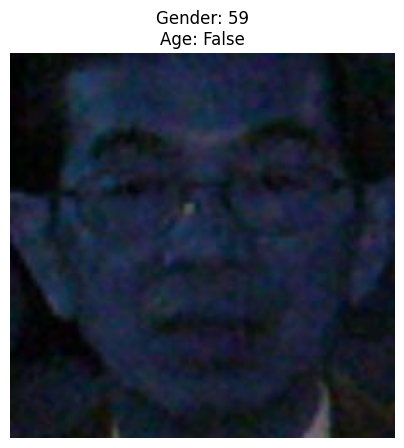

In [5]:
trn = GenderAgeClass(trn_df)
val = GenderAgeClass(val_df)

train_loader = DataLoader(trn, batch_size=32, shuffle=True,
                        drop_last=True,collate_fn=trn.collate_fn)
test_loader = DataLoader(val, batch_size=32,
                        collate_fn=val.collate_fn)

im, gen, age = trn[0]
torch_snippets.show(im, title=f'Gender: {gen}\nAge: {age}', sz=5)

ims, gens, ages = next(iter(train_loader))
torch_snippets.inspect(ims, gens, ages)

## Get the pretrained model
    Free the current parameters and change the last layer 

In [6]:
def get_model():
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
        
    model.avgpool = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten()
    )
    ### Build a nn.Module class. This class will help us split the model to predict classification and sequential 
    
    class ageGenderClassifier(nn.Module):
        def __init__(self):
            super(ageGenderClassifier, self).__init__()
            
            # First layer 
            self.intermediate = nn.Sequential(
                nn.Linear(2048, 512),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(512, 128),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(128,64),
                nn.ReLU()
            )
            
            # Next two layers are the ending layers 
            self.age_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )
            
            self.gender_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )
        
        def forward(self, x):
            x = self.intermediate(x)
            age = self.age_classifier(x)
            gender = self.gender_classifier(x)
            return gender, age
        
    model.classifier = ageGenderClassifier()
    
    # define the loss function for both gender and age 
    gender_criterion = nn.BCELoss()
    age_criterion = nn.L1Loss()
    loss_functions = gender_criterion, age_criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    return model.to(device), loss_functions, optimizer

model, criterion, optimizer = get_model()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Define function to train model on a batch

In [7]:
def train_batch(data, model, optimizer, criteria):
    model.train()
    ims, age, gender = data
    optimizer.zero_grad()
    pred_gender, pred_age = model(ims)
    gender_criterion, age_criterion = criteria
    gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    age_loss = age_criterion(pred_age.squeeze(), gender)
    
    # add both losses and perform back propagation
    total_loss = gender_loss + age_loss
    total_loss.backward()
    optimizer.step()
    return total_loss

### Define validation-batch method
    Pass in correct values to see if the model is able to predict the correct values after being trained on an epoch 

In [8]:
def validate_batch(data, model, criteria):
    img, age, gender = data
    model.eval()
    with torch.no_grad():
        pred_gender, pred_age = model(img)
        gender_criterion, age_criterion = criteria
        gender_loss = gender_criterion(pred_gender.squeeze(), gender)
        age_loss = age_criterion(pred_age.squeeze(), age)
        
        total_loss = gender_loss + age_loss
        
        pred_gender = (pred_gender > 0.5).squeeze()
        gender_accuracy = (pred_gender == gender).float().sum()
        
        age_mae = torch.abs(age-pred_age).float().sum()
        return total_loss, gender_accuracy, age_mae


### Train model over 5 epochs

1
Working on training
EPOCH: 1.000  trn_loss: 0.305  (374.51s - 3370.59s remaining)Working on Validaiton
EPOCH: 1.000  val_age_mae: 15.647  val_gender_acc: 0.906  trn_loss: 0.633  val_loss: 0.711  (374.65s - 3371.88s remaining)
EPOCH: 1.000  val_age_mae: 15.094  val_gender_acc: 0.891  trn_loss: 0.633  val_loss: 0.814  (374.79s - 3373.10s remaining)
EPOCH: 1.000  val_age_mae: 15.055  val_gender_acc: 0.865  trn_loss: 0.633  val_loss: 0.812  (374.93s - 3374.33s remaining)
EPOCH: 1.000  val_age_mae: 14.874  val_gender_acc: 0.859  trn_loss: 0.633  val_loss: 0.795  (375.06s - 3375.58s remaining)
EPOCH: 1.000  val_age_mae: 14.845  val_gender_acc: 0.844  trn_loss: 0.633  val_loss: 0.818  (375.20s - 3376.82s remaining)
EPOCH: 1.000  val_age_mae: 14.870  val_gender_acc: 0.844  trn_loss: 0.633  val_loss: 0.818  (375.34s - 3378.06s remaining)
EPOCH: 1.000  val_age_mae: 14.824  val_gender_acc: 0.839  trn_loss: 0.633  val_loss: 0.832  (375.48s - 3379.29s remaining)
EPOCH: 1.000  val_age_mae: 14.957 

100%|██████████| 111/111 [00:00<00:00, 3032.36it/s]


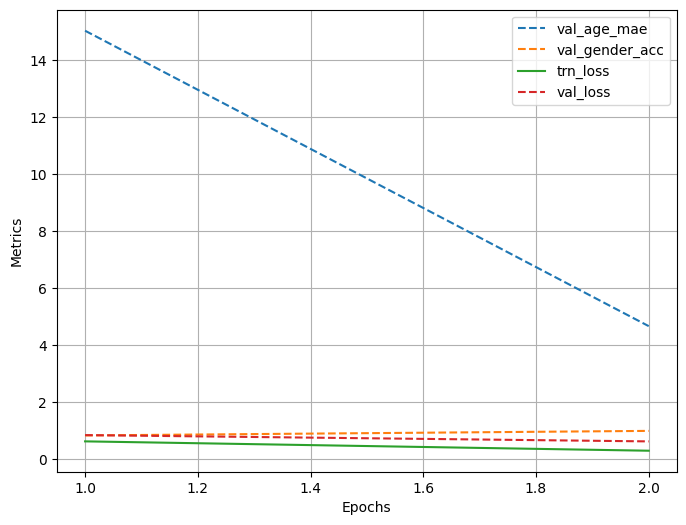

2
Working on training
EPOCH: 2.000  trn_loss: 0.470  (789.94s - 3159.76s remaining)Working on Validaiton
EPOCH: 2.000  val_age_mae: 10.194  val_gender_acc: 0.938  trn_loss: 0.446  val_loss: 0.696  (790.09s - 3160.36s remaining)
EPOCH: 2.000  val_age_mae: 11.684  val_gender_acc: 0.917  trn_loss: 0.446  val_loss: 0.744  (790.23s - 3160.92s remaining)
EPOCH: 2.000  val_age_mae: 12.501  val_gender_acc: 0.875  trn_loss: 0.446  val_loss: 0.793  (790.38s - 3161.50s remaining)
EPOCH: 2.000  val_age_mae: 13.113  val_gender_acc: 0.850  trn_loss: 0.446  val_loss: 0.800  (790.53s - 3162.11s remaining)
EPOCH: 2.000  val_age_mae: 13.456  val_gender_acc: 0.849  trn_loss: 0.446  val_loss: 0.833  (790.70s - 3162.79s remaining)
EPOCH: 2.000  val_age_mae: 13.754  val_gender_acc: 0.853  trn_loss: 0.446  val_loss: 0.821  (790.84s - 3163.35s remaining)
EPOCH: 2.000  val_age_mae: 13.858  val_gender_acc: 0.859  trn_loss: 0.446  val_loss: 0.834  (790.98s - 3163.93s remaining)
EPOCH: 2.000  val_age_mae: 13.983 

100%|██████████| 111/111 [00:00<00:00, 1020.56it/s]


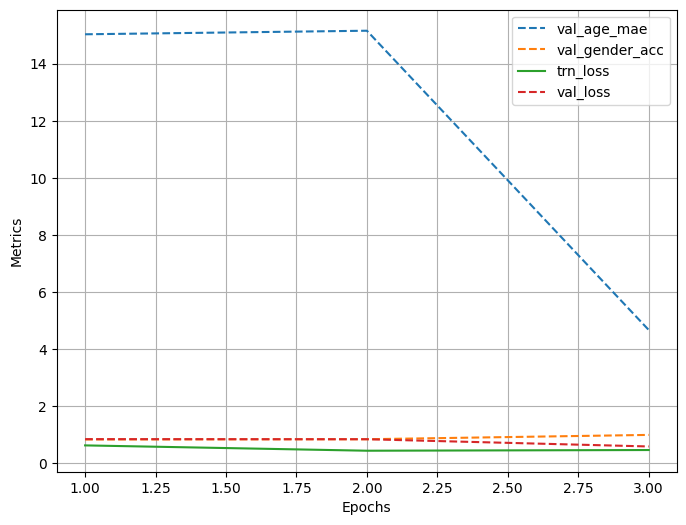

3
Working on training
EPOCH: 3.000  trn_loss: 0.342  (1220.35s - 2847.49s remaining)Working on Validaiton
EPOCH: 3.000  val_age_mae: 10.724  val_gender_acc: 0.969  trn_loss: 0.335  val_loss: 0.638  (1220.49s - 2847.82s remaining)
EPOCH: 3.000  val_age_mae: 12.163  val_gender_acc: 0.927  trn_loss: 0.335  val_loss: 0.702  (1220.63s - 2848.13s remaining)
EPOCH: 3.000  val_age_mae: 12.896  val_gender_acc: 0.891  trn_loss: 0.335  val_loss: 0.776  (1220.76s - 2848.44s remaining)
EPOCH: 3.000  val_age_mae: 13.445  val_gender_acc: 0.887  trn_loss: 0.335  val_loss: 0.783  (1220.89s - 2848.75s remaining)
EPOCH: 3.000  val_age_mae: 13.781  val_gender_acc: 0.896  trn_loss: 0.335  val_loss: 0.778  (1221.03s - 2849.07s remaining)
EPOCH: 3.000  val_age_mae: 14.014  val_gender_acc: 0.897  trn_loss: 0.335  val_loss: 0.773  (1221.17s - 2849.39s remaining)
EPOCH: 3.000  val_age_mae: 14.123  val_gender_acc: 0.898  trn_loss: 0.335  val_loss: 0.788  (1221.30s - 2849.70s remaining)
EPOCH: 3.000  val_age_mae:

100%|██████████| 111/111 [00:00<00:00, 779.29it/s]


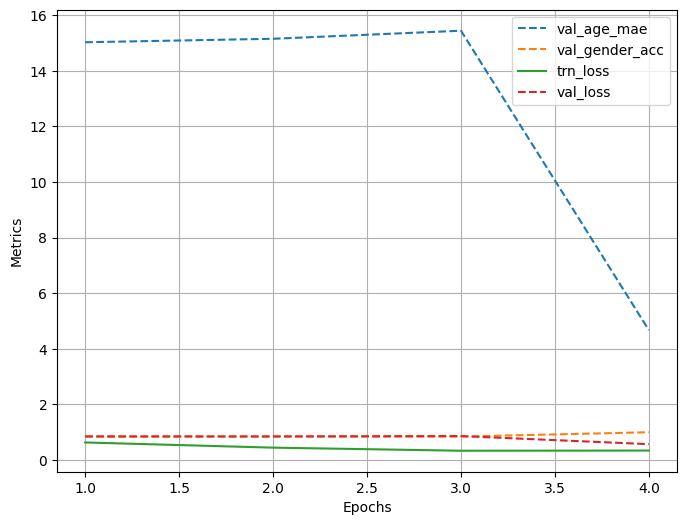

4
Working on training
EPOCH: 4.000  trn_loss: 0.124  (1709.72s - 2564.58s remaining)Working on Validaiton
EPOCH: 4.000  val_age_mae: 10.438  val_gender_acc: 0.938  trn_loss: 0.234  val_loss: 0.660  (1709.90s - 2564.85s remaining)
EPOCH: 4.000  val_age_mae: 11.930  val_gender_acc: 0.896  trn_loss: 0.234  val_loss: 0.743  (1710.07s - 2565.11s remaining)
EPOCH: 4.000  val_age_mae: 12.578  val_gender_acc: 0.875  trn_loss: 0.234  val_loss: 0.821  (1710.25s - 2565.37s remaining)
EPOCH: 4.000  val_age_mae: 13.424  val_gender_acc: 0.869  trn_loss: 0.234  val_loss: 0.856  (1710.43s - 2565.64s remaining)
EPOCH: 4.000  val_age_mae: 13.697  val_gender_acc: 0.865  trn_loss: 0.234  val_loss: 0.856  (1710.60s - 2565.90s remaining)
EPOCH: 4.000  val_age_mae: 13.800  val_gender_acc: 0.871  trn_loss: 0.234  val_loss: 0.826  (1710.78s - 2566.16s remaining)
EPOCH: 4.000  val_age_mae: 13.972  val_gender_acc: 0.867  trn_loss: 0.234  val_loss: 0.847  (1710.95s - 2566.43s remaining)
EPOCH: 4.000  val_age_mae:

100%|██████████| 111/111 [00:00<00:00, 428.59it/s]


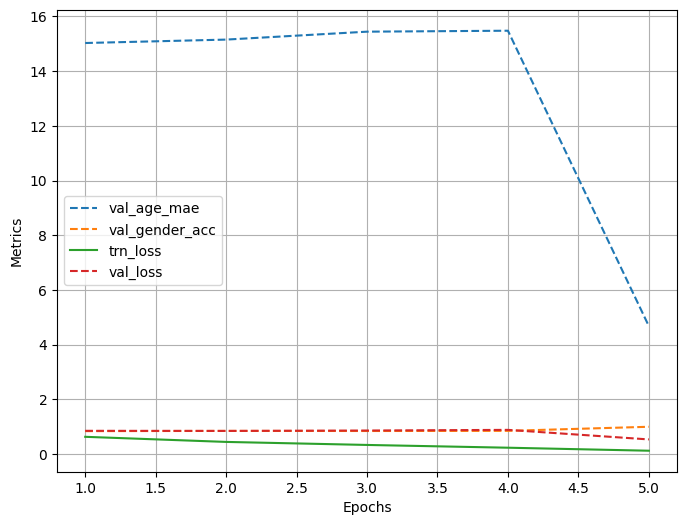

5
Working on training
EPOCH: 5.000  trn_loss: 0.308  (2149.16s - 2149.16s remaining)Working on Validaiton
EPOCH: 5.000  val_age_mae: 10.666  val_gender_acc: 0.953  trn_loss: 0.157  val_loss: 0.668  (2149.31s - 2149.31s remaining)
EPOCH: 5.000  val_age_mae: 12.081  val_gender_acc: 0.917  trn_loss: 0.157  val_loss: 0.794  (2149.44s - 2149.44s remaining)
EPOCH: 5.000  val_age_mae: 13.004  val_gender_acc: 0.883  trn_loss: 0.157  val_loss: 0.890  (2149.58s - 2149.58s remaining)
EPOCH: 5.000  val_age_mae: 13.804  val_gender_acc: 0.863  trn_loss: 0.157  val_loss: 0.927  (2149.72s - 2149.72s remaining)
EPOCH: 5.000  val_age_mae: 14.133  val_gender_acc: 0.870  trn_loss: 0.157  val_loss: 0.890  (2149.86s - 2149.86s remaining)
EPOCH: 5.000  val_age_mae: 14.274  val_gender_acc: 0.879  trn_loss: 0.157  val_loss: 0.869  (2150.00s - 2150.00s remaining)
EPOCH: 5.000  val_age_mae: 14.418  val_gender_acc: 0.871  trn_loss: 0.157  val_loss: 0.922  (2150.15s - 2150.15s remaining)
EPOCH: 5.000  val_age_mae:

100%|██████████| 111/111 [00:00<00:00, 577.20it/s]


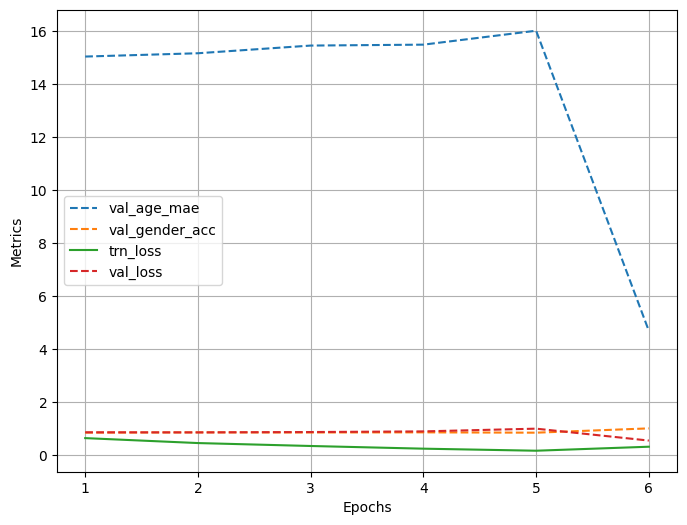

6
Working on training
EPOCH: 6.000  trn_loss: 0.102  (2573.14s - 1715.43s remaining)Working on Validaiton
EPOCH: 6.000  val_age_mae: 10.646  val_gender_acc: 0.953  trn_loss: 0.107  val_loss: 0.678  (2573.27s - 1715.51s remaining)
EPOCH: 6.000  val_age_mae: 12.266  val_gender_acc: 0.896  trn_loss: 0.107  val_loss: 0.843  (2573.40s - 1715.60s remaining)
EPOCH: 6.000  val_age_mae: 12.928  val_gender_acc: 0.883  trn_loss: 0.107  val_loss: 0.914  (2573.55s - 1715.70s remaining)
EPOCH: 6.000  val_age_mae: 13.717  val_gender_acc: 0.875  trn_loss: 0.107  val_loss: 0.937  (2573.68s - 1715.79s remaining)
EPOCH: 6.000  val_age_mae: 14.109  val_gender_acc: 0.875  trn_loss: 0.107  val_loss: 0.933  (2573.81s - 1715.88s remaining)
EPOCH: 6.000  val_age_mae: 14.265  val_gender_acc: 0.875  trn_loss: 0.107  val_loss: 0.933  (2573.95s - 1715.97s remaining)
EPOCH: 6.000  val_age_mae: 14.415  val_gender_acc: 0.867  trn_loss: 0.107  val_loss: 0.996  (2574.08s - 1716.05s remaining)
EPOCH: 6.000  val_age_mae:

100%|██████████| 111/111 [00:00<00:00, 526.16it/s]


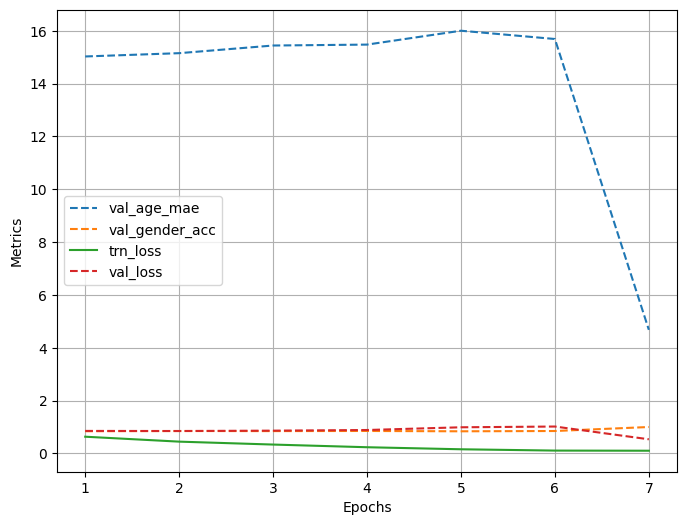

7
Working on training
EPOCH: 7.000  trn_loss: 0.023  (2995.78s - 1283.91s remaining)Working on Validaiton
EPOCH: 7.000  val_age_mae: 10.777  val_gender_acc: 0.938  trn_loss: 0.078  val_loss: 0.763  (2995.93s - 1283.97s remaining)
EPOCH: 7.000  val_age_mae: 12.275  val_gender_acc: 0.875  trn_loss: 0.078  val_loss: 0.931  (2996.08s - 1284.03s remaining)
EPOCH: 7.000  val_age_mae: 12.995  val_gender_acc: 0.867  trn_loss: 0.078  val_loss: 0.955  (2996.22s - 1284.09s remaining)
EPOCH: 7.000  val_age_mae: 13.782  val_gender_acc: 0.863  trn_loss: 0.078  val_loss: 1.001  (2996.36s - 1284.16s remaining)
EPOCH: 7.000  val_age_mae: 14.111  val_gender_acc: 0.854  trn_loss: 0.078  val_loss: 1.021  (2996.51s - 1284.22s remaining)
EPOCH: 7.000  val_age_mae: 14.309  val_gender_acc: 0.862  trn_loss: 0.078  val_loss: 1.022  (2996.66s - 1284.28s remaining)
EPOCH: 7.000  val_age_mae: 14.490  val_gender_acc: 0.852  trn_loss: 0.078  val_loss: 1.069  (2996.80s - 1284.34s remaining)
EPOCH: 7.000  val_age_mae:

100%|██████████| 111/111 [00:00<00:00, 446.30it/s]


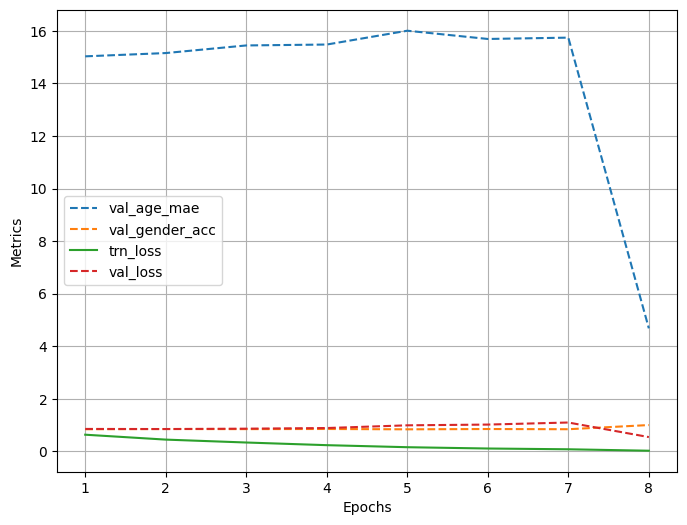

8
Working on training
EPOCH: 8.000  trn_loss: 0.008  (3455.91s - 863.98s remaining)Working on Validaiton
EPOCH: 8.000  val_age_mae: 10.778  val_gender_acc: 0.938  trn_loss: 0.061  val_loss: 0.724  (3456.06s - 864.02s remaining)
EPOCH: 8.000  val_age_mae: 11.979  val_gender_acc: 0.906  trn_loss: 0.061  val_loss: 0.827  (3456.20s - 864.05s remaining)
EPOCH: 8.000  val_age_mae: 12.859  val_gender_acc: 0.875  trn_loss: 0.061  val_loss: 0.952  (3456.35s - 864.09s remaining)
EPOCH: 8.000  val_age_mae: 13.560  val_gender_acc: 0.869  trn_loss: 0.061  val_loss: 0.982  (3456.50s - 864.13s remaining)
EPOCH: 8.000  val_age_mae: 13.827  val_gender_acc: 0.859  trn_loss: 0.061  val_loss: 1.049  (3456.65s - 864.16s remaining)
EPOCH: 8.000  val_age_mae: 13.971  val_gender_acc: 0.866  trn_loss: 0.061  val_loss: 1.040  (3456.79s - 864.20s remaining)
EPOCH: 8.000  val_age_mae: 14.152  val_gender_acc: 0.859  trn_loss: 0.061  val_loss: 1.121  (3456.94s - 864.23s remaining)
EPOCH: 8.000  val_age_mae: 14.357 

100%|██████████| 111/111 [00:00<00:00, 244.57it/s]


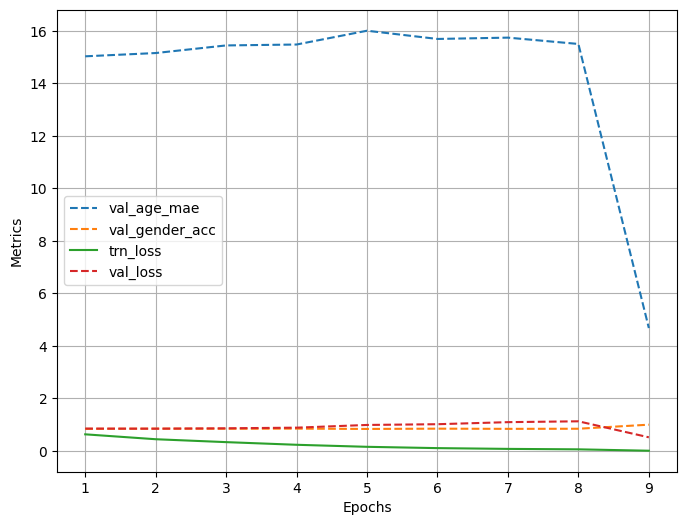

9
Working on training
EPOCH: 9.000  trn_loss: 0.001  (4162.65s - 462.52s remaining)Working on Validaiton
EPOCH: 9.000  val_age_mae: 10.982  val_gender_acc: 0.938  trn_loss: 0.050  val_loss: 0.705  (4162.89s - 462.54s remaining)
EPOCH: 9.000  val_age_mae: 12.372  val_gender_acc: 0.885  trn_loss: 0.050  val_loss: 1.000  (4163.12s - 462.57s remaining)
EPOCH: 9.000  val_age_mae: 13.154  val_gender_acc: 0.891  trn_loss: 0.050  val_loss: 1.046  (4163.36s - 462.60s remaining)
EPOCH: 9.000  val_age_mae: 13.875  val_gender_acc: 0.887  trn_loss: 0.050  val_loss: 1.046  (4163.60s - 462.62s remaining)
EPOCH: 9.000  val_age_mae: 14.091  val_gender_acc: 0.880  trn_loss: 0.050  val_loss: 1.054  (4163.84s - 462.65s remaining)
EPOCH: 9.000  val_age_mae: 14.253  val_gender_acc: 0.879  trn_loss: 0.050  val_loss: 1.064  (4164.09s - 462.68s remaining)
EPOCH: 9.000  val_age_mae: 14.419  val_gender_acc: 0.863  trn_loss: 0.050  val_loss: 1.202  (4164.33s - 462.70s remaining)
EPOCH: 9.000  val_age_mae: 14.593 

100%|██████████| 111/111 [00:00<00:00, 192.66it/s]


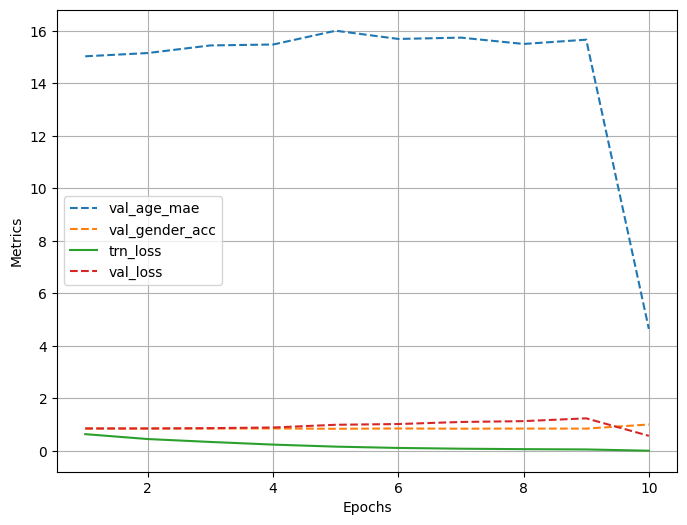

10
Working on training
EPOCH: 10.000  trn_loss: 0.044  (4905.50s - 0.00s remaining)Working on Validaiton
EPOCH: 10.000  val_age_mae: 10.613  val_gender_acc: 0.953  trn_loss: 0.040  val_loss: 0.785  (4905.74s - 0.00s remaining)
EPOCH: 10.000  val_age_mae: 12.021  val_gender_acc: 0.906  trn_loss: 0.040  val_loss: 0.993  (4905.98s - 0.00s remaining)
EPOCH: 10.000  val_age_mae: 12.965  val_gender_acc: 0.875  trn_loss: 0.040  val_loss: 1.020  (4906.22s - 0.00s remaining)
EPOCH: 10.000  val_age_mae: 13.743  val_gender_acc: 0.869  trn_loss: 0.040  val_loss: 1.094  (4906.46s - 0.00s remaining)
EPOCH: 10.000  val_age_mae: 14.113  val_gender_acc: 0.865  trn_loss: 0.040  val_loss: 1.119  (4906.70s - 0.00s remaining)
EPOCH: 10.000  val_age_mae: 14.328  val_gender_acc: 0.871  trn_loss: 0.040  val_loss: 1.120  (4906.94s - 0.00s remaining)
EPOCH: 10.000  val_age_mae: 14.403  val_gender_acc: 0.867  trn_loss: 0.040  val_loss: 1.235  (4907.18s - 0.00s remaining)
EPOCH: 10.000  val_age_mae: 14.525  val_g

100%|██████████| 111/111 [00:00<00:00, 176.81it/s]


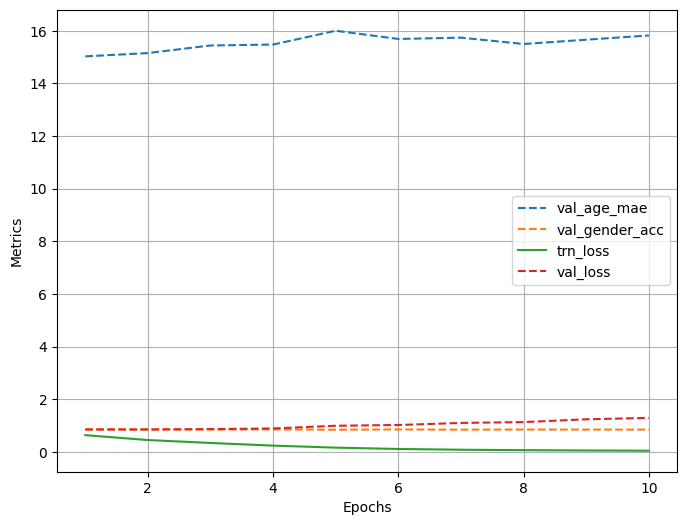

In [9]:
import time
from torch_snippets.torch_loader import Report

model, criteria, optimizer = get_model()
n_epochs = 10

log = torch_snippets.torch_loader.Report(n_epochs)

for epoch in range(n_epochs):
    print(epoch+1)
    
    # First loop, train the model
    print("Working on training")
    N = len(train_loader)
    for ix, data in enumerate(train_loader):
        if ix == N: break
        total_loss = train_batch(data, model, optimizer, criteria)
        log.record(epoch+(ix+1)/N, trn_loss=total_loss, end='\r')
    
    # Second loop, validate the model performance 
    print("Working on Validaiton")
    N = len(test_loader)
    for ix, data in enumerate(test_loader):
        if ix==N: break
        total_loss, gender_acc, age_mae = validate_batch(data, model, criteria)
        
        # calc the overall accuracy of age prediction and gender classification
        age_mae /= len(data[0])
        gender_acc /= len(data[0])
        log.record(epoch+(ix+1)/N, val_loss=total_loss,
                   val_gender_acc=gender_acc,
                   val_age_mae=age_mae, end='\r')
    log.report_avgs(epoch+1)
log.plot_epochs()
        
        


In [10]:
epochs = np.arange(1, (n_epochs + 1))
val_gender_accuracies_np = torch.tensor(val_gender_accuracies).cpu().numpy()
val_age_maes_np = torch.tensor(val_age_maes).cpu().numpy()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.flat
ax[0].plot(epochs, val_gender_accuracies_np, 'bo')
ax[1].plot(epochs, val_age_maes_np, 'r')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[1].set_ylabel('MAE')
ax[0].set_title('Validation Gender Accuracy')
ax[1].set_title('Validation Age Mean-Absolute-Error')
plt.show()

NameError: name 'val_gender_accuracies' is not defined

In [26]:
IM = torch_snippets.read("IMG_3428.HEIC")

False


[ WARN:0@16716.101] global loadsave.cpp:241 findDecoder imread_('IMG_3420.jpg'): can't open/read file: check file path/integrity


ValueError: Image could not be loaded. Please check the file path.

Image dtype: uint8
Image shape: (3088, 2316, 3)
Predicted Gender: Male, Age: [[2.5620288e-08]]


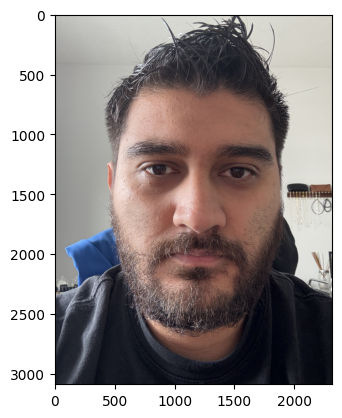

In [34]:
from PIL import Image
import pillow_heif
import numpy as np

# Load HEIC image
heif_file = pillow_heif.read_heif("IMG_3428.HEIC")
im = Image.frombytes(
    heif_file.mode, 
    heif_file.size, 
    heif_file.data
)

plt.imshow(im)
# Convert to RGB and ensure proper format
im = im.convert("RGB")  # Ensure the image is in RGB format
im_np = np.array(im, dtype=np.uint8)  # Convert to numpy array

# Debugging output
print(f"Image dtype: {im_np.dtype}")  # Expect uint8
print(f"Image shape: {im_np.shape}")  # Expect (height, width, 3)

# Preprocess the image
im_tensor = trn.preprocess_image(im_np).to(device)

# Pass the preprocessed image to the model
gender, age = model(im_tensor)

# Extract predictions
pred_gender = gender.to('cpu').detach().numpy()
pred_age = age.to('cpu').detach().numpy()

print(f"Predicted Gender: {'Female' if pred_gender > 0.5 else 'Male'}, Age: {pred_age}")